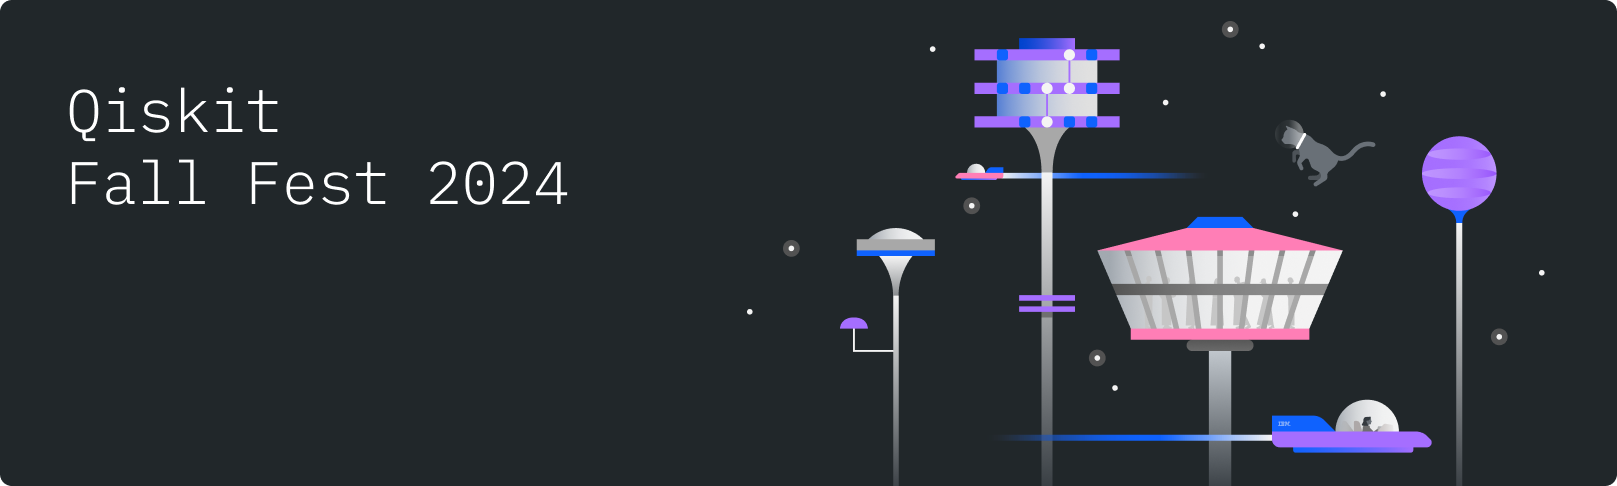

# Graded Notebook 2: Qiskit Runtime Lab

*   Difficulty: 3/5
*   Estimated Time: 60 minutes

Hi there and welcome to the **Qiskit Fall Fest**!

Whether you're a total beginner or a PhD candidate in quantum physics, there is something here for you. Thanks for joining us.  😀

As part of the Qiskit Fall Fest, IBM Quantum has created a series of notebooks for you to work through, which include coding challenges and Qiskit tutorials.

The Qiskit Fall Fest is a massive event, featuring thousands of students worldwide who are all learning about quantum computing and Qiskit. Just by being here, you're helping to make history. Your participation is helping to shape what the future of the industry will look like. Congratulations and welcome!

---

Each of these notebooks builds upon the previous learning. This first one is meant for anyone to complete, even beginners, but later notebooks are more difficult. Most participants will need to do some outside research or use a bit of trial-and-error to finish the code challenges presented in the more advanced notebooks. Don't give up! We know you can do it.

In each notebook, you will find links to documentation, tutorials, and other helpful resources you might need to solve that particular problem. You can also find most of these resources on IBM's new home for quantum education: [IBM Quantum Learning](https://learning.quantum.ibm.com/).

# Table of Contents
- [Introduction](#intro)
- [Part I: Qiskit states, the new and the old](#pt1)
  - [Exercise 1: Create and draw a singlet Bell state circuit](#exercise1)
  - [Exercise 2: Use Sampler.run](#exercise2)
  - [Exercise 3: Create and draw a W-state circuit](#exercise3)   
- [Part II: VQE with Qiskit 1.0](#pt2)
  - [Exercise 4: Create a parameterized circuit to serve as the ansatz](#exercise4)    
  - [Exercise 5: Transpile to ISA circuits](#exercise5)
  - [Exercise 6: Defining the cost function](#exercise6)
  - [Exercise 7: QiskitRuntimeService V2 Primitives, local testing mode and Sessions, a first look](#exercise7)


## Setup

Let's begin by getting all the necessary installs and imports out of the way.

If you are running things locally, you may already have these installed from a previous notebook. If you're running in the cloud, you may need to re-install for each notebook.

In [1]:
### Install Qiskit, if needed

%pip install qiskit[visualization]
%pip install qiskit_aer
%pip install qiskit_ibm_runtime
%pip install matplotlib
%pip install pylatexenc
%pip install qiskit-transpiler-service
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

  Using cached qiskit-1.2.4-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.3.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
  Using cached pylatexenc-2.10-py3-none-any.whl
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
Using cached rustworkx-0.15.1-cp38-abi3

In [2]:
### Save API Token, if needed

%set_env QXToken=19e3565cebd2c9dd2d3644d1c9a86ac1dc2027eebf40be17ad997f7c32f11df134ec034a47e9c3b94465e9cc65b0c1325bf7d0727a75bda27c9dee15902422e8

# Make sure there is no space between the equal sign
# and the beginning of your token

env: QXToken=19e3565cebd2c9dd2d3644d1c9a86ac1dc2027eebf40be17ad997f7c32f11df134ec034a47e9c3b94465e9cc65b0c1325bf7d0727a75bda27c9dee15902422e8


In [3]:
# imports
import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

This next cell is totally new. You need to import the grader information directly inside of each notebook.

In [4]:
# Setup the grader
from qc_grader.challenges.fall_fest24 import (
    grade_lab2_ex1,
    grade_lab2_ex2,
    grade_lab2_ex3,
    grade_lab2_ex4,
    grade_lab2_ex5,
    grade_lab2_ex6,
    grade_lab2_ex7,
)

## Introduction <a name="intro"></a>

This notebook is a gentle introduction to primitives of Qiskit 1.x version. This notebook leverages some the latest innovations from IBM Quantum, such as Qiskit Runtime, and will help you get up to speed on the following topics and skills:

- How to set up quantum states using Qiskit
- Leveraging Qiskit Runtime Sampler and Estimator primitives, and Runtime
- Executing circuits in quantum simulators as well as on IBM Quantum computers by using Runtime

# Part I: Qiskit states, the new and the old with Sampler <a name="pt1"></a>

***Subtitle: “Life is like a box of chocolates”***

Now it time to get your hands dirty with Python and Qiskit code. Your assignment, should you choose to accept it, will be to develop a program that samples one piece from a box that contains two chocolate candies - vanilla ('01') and raspberry ('10') flavors. Your mission is build a quantum circuit that has a same probability of getting '01' and '10' by using a 'bell state'.

There exist 4 different Bell states. You can learn about each from the [Basics of Quantum Information page](https://learning.quantum.ibm.com/course/basics-of-quantum-information/multiple-systems#bell-states)


<a id="exercise1"></a>
<a name="exercise1"></a>
<div class="alert alert-block alert-success">
    
### Exercise 1: Create and draw a singlet Bell state circuit
    
Bell circuits are specific circuits which generate Bell states, or EPR pairs, a form of entangled and normalized basis vectors. In other words, they are the circuits we use to generate entangled states, a key ingredient in quantum computations.

**Your Task:** please build a circuit that generates the $| \psi ^- \rangle$ Bell state.
    
</div>

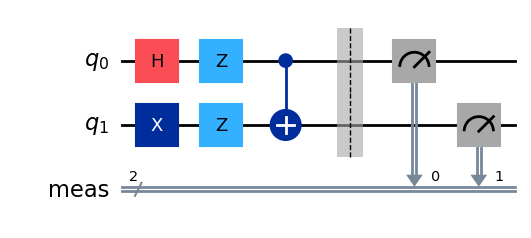

In [5]:
# Build a circuit to form a psi-minus Bell state
# Apply gates to the provided QuantumCircuit, qc

qc = QuantumCircuit(2)

### Write your code below here ###

qc.h(0)
qc.x(1)
qc.z(0)
qc.z(1)
qc.cx(0,1)

### Don't change any code past this line ###
qc.measure_all()
qc.draw('mpl')

<div class="alert alert-block alert-warning">

**Hint:** The $| \psi ^- \rangle$ Bell state uses a single Z gate, and a single X gate, both of which occur after the CNOT.

</div>

In [6]:
# Submit your answer using following code

grade_lab2_ex1(qc) # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


To observe the resulting entangled state that this circuit produces, we'll run our circuit a number of times and collect statistics on the final qubit measurements. That is the goal of the next exercise.

<a id="exercise2"></a>
<a name="exercise2"></a>
<div class="alert alert-block alert-success">
    
### Exercise 2: Use Sampler.run
    
The [Qiskit Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler) primitive ([more info on Primitives here](https://docs.quantum.ibm.com/run/primitives-get-started)) returns the sampled result according to the specified output type. It allows us to efficiently sample quantum states by executing quantum circuits and providing probability distributions of the quantum states.

**Your Task:** use the Qiskit StatevectorSampler to obtain the counts resulting from our circuit.
    
</div>

In [7]:
qc.measure_all()

### Write your code below here ###


sampler = StatevectorSampler()#Add your code here
pub = (qc)#Add your code here
job_sampler = sampler.run([pub])#Add your code here


### Don't change any code past this line ###

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'10': 478, '01': 546}


In [8]:
# Submit your answer using following code

grade_lab2_ex2(job_sampler) # Expected result type: PrimitiveJob

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


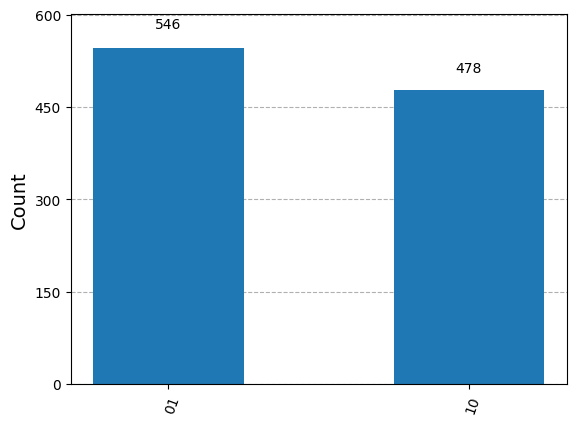

In [9]:
plot_histogram(counts_sampler)

The histogram shows an approximately even probability of finding our qubits in the `01` and the `10` states, suggesting that entanglement was performed as expected.

<a id="exercise3"></a>
<a name="exercise3"></a>
<div class="alert alert-block alert-success">
    
### Exercise 3: Create and draw a W-state circuit

Next, we will develop a program samples one piece of candy from a box that contains three chocolate candies - Vanilla (`001`), Raspberry (`010`) and Strawberry (`001`). Your mission is build a circuit that has a equal probability of returning those chocolates. For this, we will use a **W-state circuit**.

Similarly to Bell states circuit producing Bell states, W-state circuits produce [W states](https://en.wikipedia.org/wiki/W_state). Although Bell states entangle two qubits, W-states entangle three qubits.
To build our W-state, we will follow 6 simple steps:

1.  Initialize our 3 qubit circuit
2.  Perform an Ry rotation on our qubit. The specifics of this operation are provided.
3.  Perform a controlled hadamard gate on qubit 1, with control qubit 0
4.  Add a CNOT gate with control qubit 1 and target qubit 2
5.  Add a CNOT gate with control qubit 0 and target qubit 1
6.  Add a X gate on qubit 0

**Your Task:** Follow the steps to build the W-state circuit
    
</div>

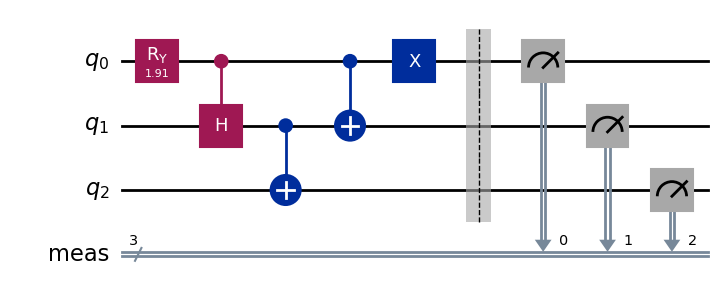

In [10]:
# Step 1
qc =QuantumCircuit(3)

# Step 2 (provided)
qc.ry(1.91063324, 0)

# Add steps 3-6 below
qc.ch(0,1)
qc.cx(1,2)
qc.cx(0,1)
qc.x(0)

### Don't change any code past this line ###
qc.measure_all()
qc.draw('mpl')

In [11]:
# Submit your answer using following code

grade_lab2_ex3(qc) # Expected result type: # Expected result type: QuantumCircuit

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


Once again, let's visualize our results:

In [12]:
sampler = StatevectorSampler()
pub = (qc)
job_sampler = sampler.run([pub], shots=10000)

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'100': 3366, '001': 3258, '010': 3376}


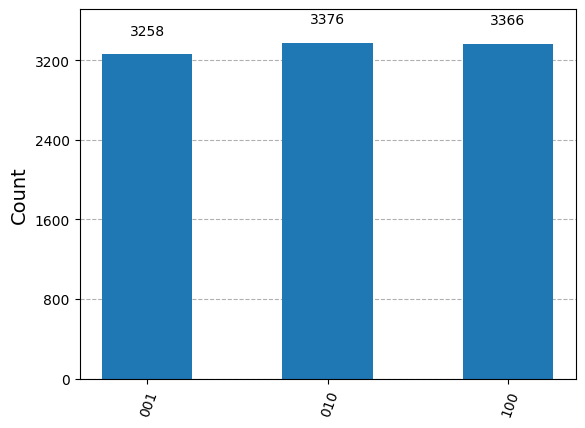

In [13]:
plot_histogram(counts_sampler)

We observe our total counts distributed in three similarly sized bins in three states, which are the three desired states for the successful creation of a W-state. Good work!

Now that we have basic circuits down, we'll start introducing and developing more complex codes with Qiskit 1.0.

# Part II: VQE with Qiskit 1.0

<a name="pt2"></a>

***Subtitle: “You never know what you're gonna get”***


When selecting a piece of chocolate candy from a box, the piece often meets our expectations. Sometimes after biting into the candy however, we find that the filling is not our favorite. This exercise leverages Qiskit Runtime and a Variational Quantum Eigensolver (VQE) to assemble a box of chocolates that hopefully meets our expectations. It uses the Qiskit Runtime Estimator to calculate the expectation values for combinations of candies in a box, and uses a Qiskit Runtime session to facilitate running a VQE algorithm to find the highest expectation value.


The core of this challenge will leverage Qiskit Runtime and a Variational Quantum Eigensolver (VQE). We will be using the Qiskit Runtime Estimator to calculate expectation values for combinations of qubits, and Qiskit Runtime Sessions to facilitate running a VQE algorithm. The challenge draws upon code from an example that experimental physicist & IBM Quantum researcher Nick Bronn created for the [Coding with Qiskit Runtime video series](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqAC8DnVoLOzg2bKE4C7ARM), specifically in [Episode 05 Primitives & Sessions](https://youtu.be/yxuH8eb4MS4?si=e3trSORNjooWlQXu), and implements it using the newest Qiskit 1.0 version.

### Let's start by creating a Pauli operator

There are three pieces of chocolate candy in a box. Each piece can either have a vanilla center or a raspberry center. The user likes vanilla centers but dislikes raspberry centers, so we'll say that picking a vanilla it is worth 1 point, but picking a raspberry it is worth -1 point. To model this as an operator, we'll create three Pauli operators and sum them together. Each piece of candy in the box is represented by a qubit, and each of these Pauli's contain expectation values for their corresponding position in the box. Summing them together results in the diagonal of the operator containing eigenvalues that represent expectation values for all eight possible combinations of candy in the box.

A Pauli operator is a matrix representing a quantum mechanical observable corresponding to a measurement of spin along a particular axis (x, y, z). Let's build one by assuming you like all of the flavors - vanilla, raspberry and chocolate!

In [14]:
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
print(pauli_op.to_matrix())

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -3.+0.j]]


### Setup and run a VQE algorithm

Now, we'll start setting up our VQE algorithm. Variational quantum eigensolvers (VQEs), are hybrid algorithms that utilize quantum and classical techniques to find the ground state of a given physical system. They are often used in quantum chemistry and optimization problems, and are promising candidates for hybrid-algorithms in noisy near-term devices.

VQEs are characterized by the use of a classical optimization algorithm to iteratively improve upon a parameterized trial solution, called an "ansatz". The aim is to solve for the ground state of a given Hamiltonian represented as a linear combination of Pauli terms.

Executing a VQE algorithm requires these three steps:

1. Setting up the Hamiltonian and ansatz (problem specification)
2. Implementing the Qiskit Runtime estimator
3. Adding the Classical optimizer and running our program

We we will follow these steps.

<a id="exercise4"></a>
<a name="exercise4"></a>
<div class="alert alert-block alert-success">
    
### Exercise 4: Create a parameterized circuit to serve as the ansatz
    
Our first task will be to set up our ansatz, or a trial solution, for our problem which we will compare against.

For this we can use Qiskit's `TwoLocal` circuit, a pre-built circuit that can be used to prepare trial wave functions for variational quantum algorithms or classification circuits for machine learning. TwoLocal circuits are parameterized circuits consisting of alternating rotation layers and entanglement layers. You can find more information about them in [Qiskit's documentation](https://docs.quantum.ibm.com/api/qiskit/circuit_library).

**Your Task:** Set up a 3-qubit TwoLocal circuit using [Ry](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RYGate) and [Rz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RZGate) rotations. Entanglement should be set to full, and entanglement blocks should use the Cz gate. Make sure you set `reps=1` and `insert_barriers=True`.

</div>

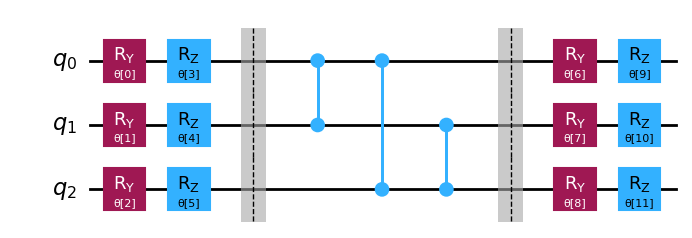

In [36]:
num_qubits = 3 #Add your code here
rotation_blocks = ['ry', 'rz']#Add your code here
entanglement_blocks = 'cz' #Add your code here
entanglement = 'full' #Add your code here

ansatz = TwoLocal(num_qubits,rotation_blocks, entanglement_blocks,entanglement,reps=1,insert_barriers=True)#Add your code here




### Don't change any code past this line ###
ansatz.decompose().draw('mpl')

In [37]:
# Submit your answer using following code

grade_lab2_ex4(num_qubits, rotation_blocks, entanglement_blocks, entanglement) # Expected result type: int, List[str], str, str

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.


From the previous figure we see that our ansatz circuit is defined by a vector of parameters θ, with the total number given by:

In [38]:
num_params = ansatz.num_parameters
num_params

12

<a id="exercise5"></a>
<a name="exercise5"></a>
<div class="alert alert-block alert-success">
    
### Exercise 5: Transpile to ISA circuits
    
In this example we will use the [FakeSherbrooke](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.fake_provider.FakeSherbrooke), a fake  (simulated) 127-qubit backend, useful for testing the transpiler and other backend-facing functionalities.

Preset pass managers are the default pass managers used by the `transpile()` function. `transpile()` provides a convenient and simple method to construct a standalone `PassManager` object that mirrors what the transpile function does when optimizing and transforming a quantum circuit for execution on a specific backend.

**Your Task:** Define the pass manager. Reference the [Qiskit documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) for more info.


</div>

In [47]:
backend_answer = FakeSherbrooke()#Add your code
optimization_level_answer = 1#Add your code

pm = generate_preset_pass_manager(backend=backend_answer,optimization_level=optimization_level_answer)

isa_circuit = pm.run(ansatz)# Add your code

<div class="alert alert-block alert-info">
    
<b>Tip: Make sure you are using the right backend! </b>

The grader was designed with **FakeSherbrooke** in mind, and therefore is expecting a 127 qubit map. If you use another backend you might encounter issues.

    
</div>

In [48]:
# Submit your answer using following code

grade_lab2_ex5(isa_circuit) # Expected result type: QuantumCircuit

Grading your answer. Please wait...
Failed: SymEngine-0.11 was asked to deserialize an object created using SymEngine-0.13.
Unable to grade your answer.


With the newest version of Qiskit Runtime, all circuits submitted to a backend must conform to the constraints of the backend’s Target. Such circuits are considered to be written in terms of that backend’s Instruction Set Architecture ([ISA](https://www.ibm.com/quantum/blog/isa-circuits?social_post=sf187802680&sf187802680=1)) — i.e., the set of instructions the device can understand and execute. These Target constraints are defined by factors like the device’s native basis gates, its qubit connectivity, and when relevant, its pulse and other instruction timing specifications.
To visualize our ISA circuits we can run:

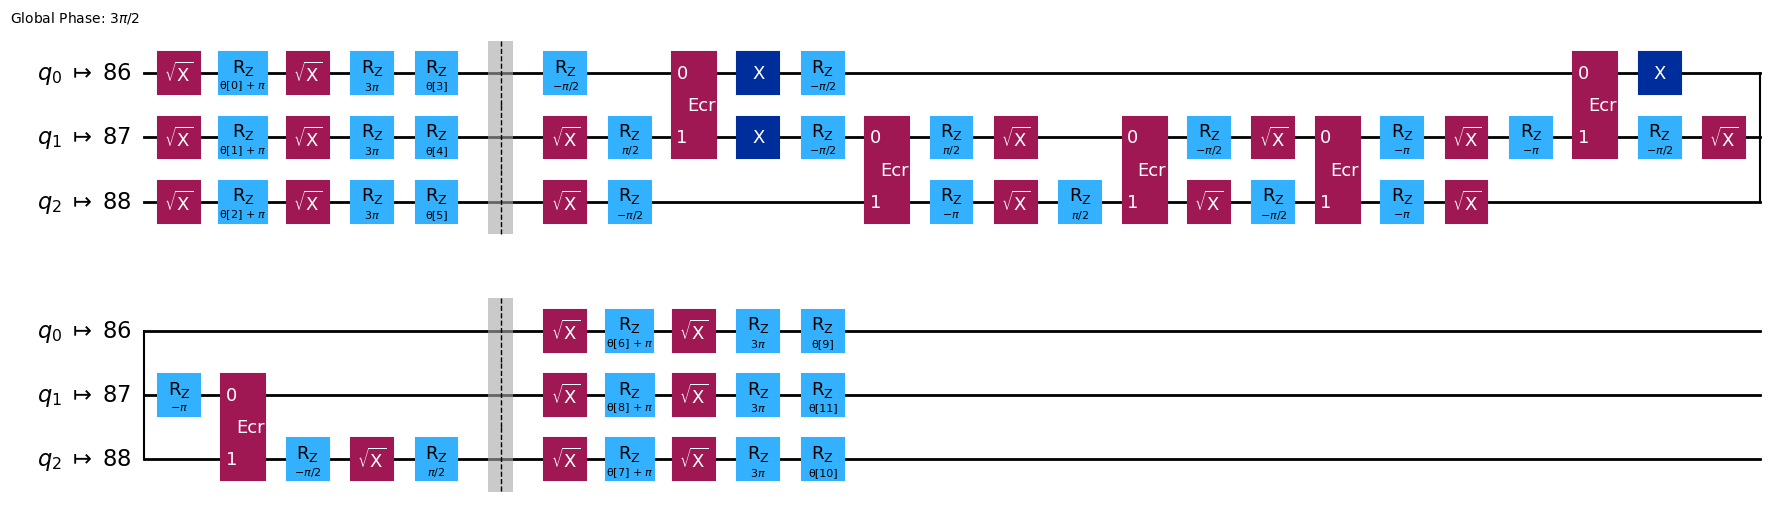

In [49]:
isa_circuit.draw('mpl', idle_wires=False)

As you can see, after transpilation, the circuit only contain the native basis gates of the backend. For more details on ISA circuits check out these resources from the IBM team:

- [What are ISA circuits?](https://www.ibm.com/quantum/blog/isa-circuits)
- [Understanding the new ISA circuits requirement](https://docs.quantum.ibm.com/announcements/news/2024-05-06-ISA-circuit-requirement#understanding-the-new-isa-circuits-requirement)

You can run the next cell to define our Hamiltonian, then move on to Exercise 6.

In [50]:
# Define our Hamiltonian
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)

<a id="exercise6"></a>
<a name="exercise6"></a>
<div class="alert alert-block alert-success">
    
### Exercise 6: Defining the cost function
    
Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function. The cost function for our VQE is simple: the energy!

**Your Task:** Define a cost function by using Qiskit Runtime Estimator to find the energy for a given parameterized state and our Hamiltonian.

</div>

In [61]:
def cost_func(params, ansatz, hamiltonian, estimator, callback_dict):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = estimator.run(ansatz,hamiltonian,params)#Add your code
    result = pub.result()#Add your code
    energy = result.values[0]#Add your code

    callback_dict["iters"] += 1#Add your code
    callback_dict["prev_vector"] = params#Add your code
    callback_dict["cost_history"].append(energy)#Add your code


### Don't change any code past this line ###
    print(energy)
    return energy, result

In [62]:
# Submit your answer using following code

grade_lab2_ex6(cost_func) # Expected result type: Callable

TypeError: EstimatorV2.run() takes 2 positional arguments but 3 were given

Callback functions are a standard way for users to obtain additional information about the status of an iterative algorithm (such as VQE). However, it is possible to do much more than this. Here, we use a mutable object (dictionary), to store resulting vector at each iteration of our algorithm, in case we need to restart the routine due to failure or return the another iteration number.

In [63]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

### Using the Classical Optimizer

We can now use a classical optimizer of our choice to minimize the cost function.
In real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well. Here, we can use SciPy routines.

To begin the routine, we specify a random initial set of parameters:

In [64]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([3.38813861, 3.27815247, 0.43320677, 5.77210843, 4.57447992,
       2.45419798, 3.12222219, 1.50092055, 1.47373852, 2.27356924,
       3.25675531, 1.50863482])

<a id="exercise7"></a>
<a name="exercise7"></a>
<div class="alert alert-block alert-success">
    
### Exercise 7: QiskitRuntimeService V2 Primitives, local testing mode, and Sessions
    

Next, we will use the new QiskitRuntimeService [V2 primitives](https://docs.quantum.ibm.com/api/migration-guides/v2-primitives): [EstimatorV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) and [SamplerV2](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2).

The new Estimator interface lets you specify a single circuit and multiple observables and parameter value sets for that circuit, so that sweeps over parameter value sets and observables can be efficiently specified. Previously, you had to specify the same circuit multiple times to match the size of the data to be combined. Also, while you can still use optimization_level and resilience_level as the simple knobs, V2 primitives give you the flexibility to turn on or off individual error mitigation / suppression methods to customize them for your needs.

SamplerV2 is simplified to focus on its core task of sampling the quantum register from the execution of quantum circuits. It returns the samples, whose type is defined by the program, without weights. The output data is also separated by the output register names defined by the program. This change enables future support for circuits with classical control flow.

We will also use Qiskit's 1.0 [local testing mode](https://docs.quantum.ibm.com/verify/local-testing-mode). Local testing mode (available with qiskit-ibm-runtime 0.22.0 or later) can be used to help develop and test programs before fine-tuning them and sending them to real quantum hardware.

**Your Task:** Use local testing mode to verify your program, then change the backend name to run it on an IBM Quantum system.

</div>

In [65]:
### Select a Backend
## Use FakeSherbrooke to simulate with noise that matches closer to the real experiment. This will run slower.
## Use AerSimulator to simulate without noise to quickly iterate. This will run faster.

#backend = FakeSherbrooke()
backend = AerSimulator()

# ### Don't change any code past this line ###

# Here we have updated the cost function to return only the energy to be compatible with recent scipy versions (>=1.10)
def cost_func_2(*args, **kwargs):
    energy, result = cost_func(*args, **kwargs)
    return energy

estimator = Estimator(backend)

res = minimize(
    cost_func_2,
    x0,
    args=(isa_circuit, hamiltonian_isa, estimator, callback_dict),
    method="cobyla",
    options={'maxiter': 30})

TypeError: EstimatorV2.run() takes 2 positional arguments but 3 were given

In [ ]:
# Submit your answer using following code

grade_lab2_ex7(res) # Expected result type: OptimizeResult

<div class="alert alert-block alert-info">
    
<b>Tip: Increase `maxiter` if you do not see convergence </b>

If the cost is not converging, increase the `maxiter` (100 is an appropriate number) and run Ex 7 again.
    
</div>

Let's look at our results:

In [ ]:
fig, ax = plt.subplots()
plt.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.draw()

🎉 As expected our VQE algorithm minimized our energy across iterations, until reaching the ground state. We have now successfully implemented a VQE algorithm using brand-new Qiskit 1.0 functionalities!

Thank you for completing this notebook, and good luck with the remaining ones!

# Additional information

**Created by:** James Weaver, Maria Gragera Garces

**Advised by:** Junye Huang

**Version:** 1.3.0